In [10]:
import argparse
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow import keras
import zlib

import tensorflow_model_optimization as tfmot   

# parser = argparse.ArgumentParser()
# parser.add_argument('--version', type=str, required=True, help='version')
# args = parser.parse_args()



In [11]:
from platform import python_version

print(python_version())

3.7.9


In [12]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

column_indices = [2, 5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

print (mean.shape)

(2,)


# WindowGenerator

In [45]:
input_width = 6
# version = args.version
# if args.version == "a" :                
#     output_steps = 3
# if args.version == "b" :
#     output_steps = 9

output_steps = 1


class WindowGenerator:
    def __init__(self, input_width, output_steps, mean, std):
        self.input_width = input_width
        self.output_steps = output_steps
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])


    def split_window(self, features):
        inputs = features[:, :self.input_width, :]        # for example if total window size = 9 input =  [:,:6 ,:] --> output [:,-3: , ] outpu_tstep = 3 
        labels = features[:, -self.output_steps :, :]

        inputs.set_shape([None, self.input_width, 2])
        labels.set_shape([None, self.output_steps,2])

        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, train):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length = input_width + self.output_steps,                       #### this change because now the total depends on the output widht
                sequence_stride = 1,
                batch_size = 32)
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds



In [46]:
# window = np.arange(18)
# window = window.reshape(9,2)
# print(len(window))
# print(window)
# print(window[:6].shape)
# print(window[-3:].shape)

In [47]:
generator = WindowGenerator(input_width, output_steps, mean, std)
train_ds = generator.make_dataset(train_data, True)
val_ds = generator.make_dataset(val_data, False)
test_ds = generator.make_dataset(test_data, False)

# checking the shapes 

In [48]:
print(f"data shape before split {data.shape}")

print(f"train_data {train_data.shape}")

print(f"val_data {val_data.shape}")

print(f"test_data {test_data.shape}")



data shape before split (420551, 2)
train_data (294385, 2)
val_data (84110, 2)
test_data (42056, 2)


In [49]:
# it = iter(test_ds)

In [50]:
"""
inp , label = next(it)
print(inp[0,0,:])
print(label[0,0,:])
"""

'\ninp , label = next(it)\nprint(inp[0,0,:])\nprint(label[0,0,:])\n'

# MultiOutputMAE

In [51]:
# # Exercise 1.7
class MultiOutputMAE(tf.keras.metrics.Metric):
    def __init__(self, name='mean_absolute_error', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight('total', initializer='zeros', shape=(2,))
        self.count = self.add_weight('count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_pred- y_true)     
        error = tf.reduce_mean(error, axis=[0,1])  # compute the mean for all samples in the batch for each feature (temp , hum) ==> output shape = (2,)
        self.total.assign_add(error)
        self.count.assign_add(1.)

        return

    def reset_states(self):
        self.count.assign(tf.zeros_like(self.count))
        self.total.assign(tf.zeros_like(self.total))

    def result(self):
        result = tf.math.divide_no_nan(self.total, self.count)

        return result

# building the models

In [52]:
alpha = 0.03
# alpha = 1
sparsity = 0.9
Structured = True
if Structured == True :
    model_version = f"_V( {version}_alpha={alpha} )"
else :
    model_version = f"_V( {version}_Sparcity ={sparsity} )"
mymodel = 'mlp'+ model_version
chk_path = f'./callback_{mymodel}_chkp/{mymodel}_chkp_best'     # path for saving the best model 
TFLITE = mymodel + ".tflite"                                    # path for saving the best model after converted to TF.lite model 

print(mymodel)

mlp_V( b_alpha=0.03 )


In [53]:
#################################### Build models with Structured Pruning via width Multiplier #####################################################
def bulid_models_Structured (alpha = alpha , version = version , input_width = input_width ,output_steps = output_steps ,model_version = model_version  ) :
    mlp = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (input_width,2) , name='Flatten'),
            tf.keras.layers.Dense(int(128 *alpha), activation='relu' , name='Dense1'),
            tf.keras.layers.Dense(int(128 *alpha), activation='relu' , name='Dense2'),
            tf.keras.layers.Dense(units = 2*output_steps , name='Output_layes'), 
            tf.keras.layers.Reshape([output_steps, 2])
        ])

    ############################################################################
    cnn = tf.keras.Sequential([
            tf.keras.layers.Conv1D(input_shape = (input_width,2) , filters=int(64 *alpha), kernel_size=3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=int(64 *alpha), activation='relu'),
            tf.keras.layers.Dense(units=2*output_steps), 
            tf.keras.layers.Reshape([output_steps, 2])
        ])

  

    MODELS = {'mlp'+ model_version: mlp, 'cnn'+ model_version: cnn }
    return MODELS 

####################################       Build models with UnStructured Pruning         #####################################################

def bulid_models_UnStructured ( version = version , input_width = input_width ,output_steps = output_steps ,model_version = model_version  ) :
    mlp = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (input_width,2) , name='Flatten'),
            tf.keras.layers.Dense(128, activation='relu' , name='Dense1'),
            tf.keras.layers.Dense(128, activation='relu' , name='Dense2'),
            tf.keras.layers.Dense(units = 2*output_steps , name='Output_layes'), 
            tf.keras.layers.Reshape([output_steps, 2])
        ])

    ############################################################################
    cnn = tf.keras.Sequential([
            tf.keras.layers.Conv1D(input_shape = (input_width,2) , filters=64, kernel_size=3, activation='relu' , name= "Conv1D-1"),
            tf.keras.layers.Flatten(name='Flatten'),
            tf.keras.layers.Dense(units=64, activation='relu', name='Dense-1'),
            tf.keras.layers.Dense(units=2*output_steps), 
            tf.keras.layers.Reshape([output_steps, 2])
        ])

 

    MODELS = {'mlp'+ model_version: mlp, 'cnn'+ model_version: cnn }
    return MODELS 

if Structured == True :
    MODELS = bulid_models_Structured()
else :
    MODELS = bulid_models_UnStructured()

In [54]:
# ! pip install pydot
# ! pip install pydotplus
# ! pip install graphviz
# print(model.summary())

In [55]:
print(MODELS.keys())

dict_keys(['mlp_V( b_alpha=0.03 )', 'cnn_V( b_alpha=0.03 )'])


# Define losses & Optimizer & metrics

In [56]:
def get_model(model = mymodel ):
    model = MODELS[model]
    loss =   tf.keras.losses.MeanSquaredError()                       #tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()
    metrics = [MultiOutputMAE()]

    # Training and optimizing

    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    
    return model


# define call backs 

In [57]:
# Create TEMP_HUM_VAL  callback to print the MAE for Temperature and humidity in more interpetable format 
class TEMP_HUM_VAL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        hum = logs["val_mean_absolute_error"][1]
        temp = logs["val_mean_absolute_error"][0]
        MAE = logs["val_mean_absolute_error"]
        print(f"\n Temp MAE = {temp:.3f}, Hum MAE = {hum:.3f}    ")
        # return temp , hum


mycallback = TEMP_HUM_VAL()

In [58]:
# Create checkpoint callback to save the best model 
cp_callback = keras.callbacks.ModelCheckpoint(
    f'./callback_{mymodel}_chkp/{mymodel}_chkp_best',
    # './callback_test_chkp/chkp_best',
    monitor='val_loss',
    verbose=0, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch')

In [59]:
if Structured == True :
    model = get_model(mymodel)
    history = model.fit(train_ds, epochs=20,   validation_data=val_ds,callbacks=[mycallback ,cp_callback ])
if Structured == False :
# Create  Unstructiured Pruning Callback  to to apply pruning during Training and fitting the model
    model = MODELS[mymodel]
    # Define the sparsity scheduler
    pruning_params = {'pruning_schedule':
    tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.30,
    final_sparsity=sparsity,
    begin_step=len(train_ds)*5,
    end_step=len(train_ds)*15)
    }

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    model = prune_low_magnitude(model, **pruning_params)
    # Define the pruning callback
    PruningCallback = [tfmot.sparsity.keras.UpdatePruningStep()]

Epoch 1/20
9194/9200 [============================>.] - ETA: 0s - loss: 405.8737 - mean_absolute_error: 11.1127

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



 Temp MAE = 7.396, Hum MAE = 3.788    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 14s 1ms/step - loss: 405.6388 - mean_absolute_error: 11.1090 - val_loss: 50.5982 - val_mean_absolute_error: 5.5921
Epoch 2/20
  92/9200 [..............................] - ETA: 10s - loss: 105.4195 - mean_absolute_error: 8.1149 

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9185/9200 [============================>.] - ETA: 0s - loss: 14.0779 - mean_absolute_error: 2.3786


 Temp MAE = 1.017, Hum MAE = 2.745    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 14.0746 - mean_absolute_error: 2.3778 - val_loss: 9.2073 - val_mean_absolute_error: 1.8807
Epoch 3/20
  93/9200 [..............................] - ETA: 9s - loss: 6.6028 - mean_absolute_error: 1.6144 

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9183/9200 [============================>.] - ETA: 0s - loss: 8.3187 - mean_absolute_error: 1.6516


 Temp MAE = 0.974, Hum MAE = 2.458    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 8.3195 - mean_absolute_error: 1.6521 - val_loss: 8.1729 - val_mean_absolute_error: 1.7160
Epoch 4/20
  84/9200 [..............................] - ETA: 11s - loss: 4.9039 - mean_absolute_error: 1.2421

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9199/9200 [============================>.] - ETA: 0s - loss: 7.8577 - mean_absolute_error: 1.5927


 Temp MAE = 0.712, Hum MAE = 2.481    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 13s 1ms/step - loss: 7.8577 - mean_absolute_error: 1.5928 - val_loss: 7.6889 - val_mean_absolute_error: 1.5964
Epoch 5/20
  85/9200 [..............................] - ETA: 11s - loss: 4.4825 - mean_absolute_error: 1.2836

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9192/9200 [============================>.] - ETA: 0s - loss: 7.6449 - mean_absolute_error: 1.5636


 Temp MAE = 0.727, Hum MAE = 2.417    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 7.6473 - mean_absolute_error: 1.5640 - val_loss: 7.4485 - val_mean_absolute_error: 1.5715
Epoch 6/20
  94/9200 [..............................] - ETA: 9s - loss: 5.1471 - mean_absolute_error: 1.2545 

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9162/9200 [============================>.] - ETA: 0s - loss: 7.5198 - mean_absolute_error: 1.5420


 Temp MAE = 0.644, Hum MAE = 2.350    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 13s 1ms/step - loss: 7.5375 - mean_absolute_error: 1.5438 - val_loss: 7.2554 - val_mean_absolute_error: 1.4971
Epoch 7/20
  90/9200 [..............................] - ETA: 10s - loss: 4.4845 - mean_absolute_error: 1.2082

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9168/9200 [============================>.] - ETA: 0s - loss: 7.4374 - mean_absolute_error: 1.5265
 Temp MAE = 0.694, Hum MAE = 2.552    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.4469 - mean_absolute_error: 1.5276 - val_loss: 7.5712 - val_mean_absolute_error: 1.6234
Epoch 8/20
9183/9200 [============================>.] - ETA: 0s - loss: 7.3865 - mean_absolute_error: 1.5149
 Temp MAE = 0.636, Hum MAE = 2.440    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.3932 - mean_absolute_error: 1.5156 - val_loss: 7.2854 - val_mean_absolute_error: 1.5380
Epoch 9/20
9200/9200 [==============================] - ETA: 0s - loss: 7.3660 - mean_absolute_error: 1.5099


 Temp MAE = 0.616, Hum MAE = 2.352    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 7.3660 - mean_absolute_error: 1.5099 - val_loss: 7.1715 - val_mean_absolute_error: 1.4843
Epoch 10/20
   1/9200 [..............................] - ETA: 1:50 - loss: 11.5580 - mean_absolute_error: 2.3319

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9178/9200 [============================>.] - ETA: 0s - loss: 7.3239 - mean_absolute_error: 1.5016
 Temp MAE = 0.635, Hum MAE = 2.477    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.3323 - mean_absolute_error: 1.5026 - val_loss: 7.3675 - val_mean_absolute_error: 1.5560
Epoch 11/20
9200/9200 [==============================] - ETA: 0s - loss: 7.3207 - mean_absolute_error: 1.4977


 Temp MAE = 0.591, Hum MAE = 2.332    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 7.3207 - mean_absolute_error: 1.4977 - val_loss: 7.0951 - val_mean_absolute_error: 1.4616
Epoch 12/20
  44/9200 [..............................] - ETA: 10s - loss: 5.0770 - mean_absolute_error: 1.2909 

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9199/9200 [============================>.] - ETA: 0s - loss: 7.3093 - mean_absolute_error: 1.4975


 Temp MAE = 0.547, Hum MAE = 2.303    
INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


INFO:tensorflow:Assets written to: ./callback_mlp_V( b_alpha=0.03 )_chkp/mlp_V( b_alpha=0.03 )_chkp_best/assets


9200/9200 [==============================] - 12s 1ms/step - loss: 7.3093 - mean_absolute_error: 1.4976 - val_loss: 6.9979 - val_mean_absolute_error: 1.4250
Epoch 13/20
  89/9200 [..............................] - ETA: 10s - loss: 3.5382 - mean_absolute_error: 1.0840

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


9173/9200 [============================>.] - ETA: 0s - loss: 7.2922 - mean_absolute_error: 1.4912
 Temp MAE = 0.614, Hum MAE = 2.369    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.2947 - mean_absolute_error: 1.4920 - val_loss: 7.3187 - val_mean_absolute_error: 1.4916
Epoch 14/20
9160/9200 [============================>.] - ETA: 0s - loss: 7.2754 - mean_absolute_error: 1.4898
 Temp MAE = 0.679, Hum MAE = 2.603    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.2901 - mean_absolute_error: 1.4913 - val_loss: 7.5536 - val_mean_absolute_error: 1.6408
Epoch 15/20
9195/9200 [============================>.] - ETA: 0s - loss: 7.2815 - mean_absolute_error: 1.4893
 Temp MAE = 0.688, Hum MAE = 2.505    
9200/9200 [==============================] - 12s 1ms/step - loss: 7.2827 - mean_absolute_error: 1.4893 - val_loss: 7.4622 - val_mean_absolute_error: 1.5963
Epoch 16/20
9167/9200 [============================>.] - ETA: 0s - loss: 7.2693 - mean_absolute_e

# Model Trianing

In [60]:
if Structured == False :
    loss =   tf.keras.losses.MeanSquaredError()                       
    optimizer = tf.keras.optimizers.Adam()
    metrics = [MultiOutputMAE()]
    input_shape = [32, 6, 2]
    model.build(input_shape)
    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    history = model.fit(train_ds, epochs=50,   validation_data=val_ds,callbacks=[ PruningCallback])

    model_to_export = tfmot.sparsity.keras.strip_pruning(model)

    
############################## Print Model Summary ####################
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 12)                0         
                                                                 
 Dense1 (Dense)              (None, 3)                 39        
                                                                 
 Dense2 (Dense)              (None, 3)                 12        
                                                                 
 Output_layes (Dense)        (None, 18)                72        
                                                                 
 reshape_2 (Reshape)         (None, 9, 2)              0         
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________
None


# print the training results 

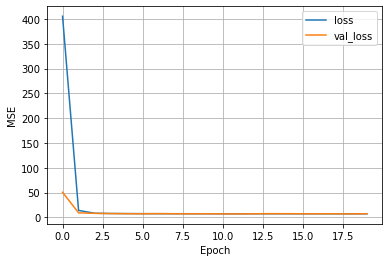

In [61]:

import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.savefig(mymodel+".png")

plot_loss(history)

# Evaluation Model 

In [62]:
def Pruned_Model_evaluate_and_compress_to_TFlite(model = model , model_to_export=None,tflite_model_dir =  TFLITE , model_name = mymodel  ):
    
    if not os.path.exists('./Pruned_models'):
        os.makedirs('./Pruned_models')
    # Model Evaluation
    loss, error = model.evaluate(test_ds)
    print(f'Temp mae = {error[0]:.3f}: , HUM mae = {error[1]:.3f} ')  
    # Convert to TF lite without Quantization 
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()  
    # Write the model in binary formate and save it 
    with open(tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed =  f"compressed_{TFLITE}"
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print(f"the model is saved successfuly to {tflite_model_dir}")
    return Compressed , tflite_model_dir 

In [63]:
def apply_Quantization(tflite_model_dir =  TFLITE ,  PQT = False , WAPQT = False , Structured = Structured , saving_path = None ): 
    if Structured == False :
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if Structured == True :
        converter = tf.lite.TFLiteConverter.from_saved_model(saving_path)
    # Apply weight only quantization 
    if PQT == True :
        tflite_model_dir = f"PQT_{tflite_model_dir}"
        converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
        tflite_model = converter.convert()
    # Apply weight + Activation  quantization 
    if WAPQT == True :
        converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
        converter.representative_dataset = representative_dataset_gen
        tflite_model = converter.convert()
        
        tflite_model_dir = f"WAPQT_{tflite_model_dir}"
      
    # Write the model in binary formate and save it 
    with open(tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed =  f"compressed_{tflite_model_dir}"
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print(f"the model is saved successfuly to {tflite_model_dir}")
    return Compressed , tflite_model_dir 

In [64]:
# Function for weight and activations quantization 
def representative_dataset_gen():
    for x, _ in train_ds.take(1000):
        yield [x]

In [65]:
def S_pruning_Model_evaluate_and_compress_to_TFlite( tflite_model_dir =  TFLITE , chk_path = chk_path , model_name = mymodel , PQT = False , WAPQT = False , Structured = Structured):
    if not os.path.exists('./models'):
        os.makedirs('./models')
    model = tf.keras.models.load_model(filepath = chk_path , custom_objects={'MultiOutputMAE':MultiOutputMAE})

    run_model = tf.function(lambda x: model(x))
    # input_shape = model.inputs[0].shape.as_list()
    # input_shape[0] = batch_size
    # func = tf.function(model).get_concrete_function(
    # tf.TensorSpec(input_shape, model.inputs[0].dtype))
    concrete_func = run_model.get_concrete_function(tf.TensorSpec([1, 6, 2], tf.float32))
    saving_path = os.path.join('.','models', model_name)
    model.save(saving_path ,signatures=concrete_func )

    best_model = tf.keras.models.load_model(filepath = saving_path , custom_objects={'MultiOutputMAE':MultiOutputMAE})
    loss, error = best_model.evaluate(test_ds)
    print(f'Temp mae = {error[0]:.3f}: , HUM mae = {error[1]:.3f} ')
    # Convert to TF lite without Quantization 
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()  

    # Write the model in binary formate and save it 
    with open(tflite_model_dir, 'wb') as fp:
        fp.write(tflite_model)
    Compressed = "compressed_"+tflite_model_dir 
    with open(Compressed, 'wb') as fp:
        tflite_compressed = zlib.compress(tflite_model)
        fp.write(tflite_compressed)
    print(f"the model is saved successfuly to {tflite_model_dir}")
    return Compressed , tflite_model_dir , saving_path

# load_and_evaluation of TF lite model 

In [66]:
def load_and_evaluation(path, dataset):
    interpreter = tf.lite.Interpreter(model_path = path) 
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    dataset = test_ds.unbatch().batch(1)

    outputs = []
    labels = []
    print(dataset)

    for data in dataset:
        my_input = np.array(data[0], dtype = np.float32)
        label = np.array(data[1], dtype = np.float32)
        # print (f"my_input = {my_input}")
        # print(f"label = {label}")

    
            
        labels.append(label)

        interpreter.set_tensor(input_details[0]['index'], my_input)
        interpreter.invoke()
        my_output = interpreter.get_tensor(output_details[0]['index'])
        
        outputs.append(my_output[0])

    outputs = np.squeeze( np.array(outputs))
    labels = np.squeeze(np.array(labels))

    
    error = np.absolute(outputs - labels)
  
    mean_axis_1 = np.mean(error , axis = 1)     #  ==>  np.sum(error, axis = 1)/labels.shape[1]
    
    mae = np.mean(mean_axis_1 , axis = 0)  #  ==> np.sum(mean_axis_1, axis = 0) /mean_axis_1.shape[0]
    temp_MAE = mae[0] 
    hum_MAE = mae[1]
    print("*"*50,"\n",f" Excuting the model {path} ")
    print("*"*50,"\n",f" mae is {mae} of shape {mae.shape} ")
    print("*"*50,"\n",f'Temp mae = {mae[0]:.3f}: , HUM mae = {mae[1]:.3f} ')
    
    # check version "a" requirment
    if version == "a" :
        if temp_MAE <= 0.3 and hum_MAE <= 1.2 :
            print ("*"*50,"\n","achieved the requirments " )
        else :
            print ("*"*50,"\n","Not achieved the requirments" )
    # check version "b" requirment        
    if version == "b" :
        if temp_MAE <= 0.7 and hum_MAE <= 2.5 :
            print ("*"*50,"\n","achieved the requirments " )
        else :
            print ("*"*50,"\n","Not achieved the requirments" ) 

#     return mae 



# get the size of tf_lite model 

In [67]:
def getsize(file):
    st = os.stat(file)
    size = st.st_size
    return size

### Without Quantization

In [68]:
if Structured == False :
    tflite_model_dir_Compressed ,tf_lite_model_path = Pruned_Model_evaluate_and_compress_to_TFlite(model_to_export=model_to_export)
if Structured == True :
    tflite_model_dir_Compressed ,tf_lite_model_path, saving_path  = S_pruning_Model_evaluate_and_compress_to_TFlite(TFLITE)
# print(b)
tflite_size = getsize(tf_lite_model_path)
compressed_tflite_size = getsize(tflite_model_dir_Compressed )
print(f" \n Size of TF.lite model is {tflite_size /1000} KB")
print(f" \n Size of compressed_tflite model is {compressed_tflite_size /1000} KB")
print(tf_lite_model_path)

INFO:tensorflow:Assets written to: ./models/mlp_V( b_alpha=0.03 )/assets


INFO:tensorflow:Assets written to: ./models/mlp_V( b_alpha=0.03 )/assets


  56/1314 [>.............................] - ETA: 2s - loss: 4.7850 - mean_absolute_error: 1.1648 

/home/students/s289265/.local/lib/python3.7/site-packages/keras/engine/training.py:1841: UserWarning: Metric MultiOutputMAE implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1314/1314 [==============================] - 2s 1ms/step - loss: 7.4013 - mean_absolute_error: 1.5083
Temp mae = 0.578: , HUM mae = 2.439 


INFO:tensorflow:Assets written to: /tmp/tmpm2wnjfue/assets


INFO:tensorflow:Assets written to: /tmp/tmpm2wnjfue/assets


the model is saved successfuly to mlp_V( b_alpha=0.03 ).tflite
 
 Size of TF.lite model is 3.536 KB
 
 Size of compressed_tflite model is 1.764 KB
mlp_V( b_alpha=0.03 ).tflite


In [69]:
load_and_evaluation(tf_lite_model_path , test_ds) 

<BatchDataset shapes: ((None, 6, 2), (None, 9, 2)), types: (tf.float32, tf.float32)>
************************************************** 
  Excuting the model mlp_V( b_alpha=0.03 ).tflite 
************************************************** 
  mae is [0.5777065 2.4384937] of shape (2,) 
************************************************** 
 Temp mae = 0.578: , HUM mae = 2.438 
************************************************** 
 achieved the requirments 


### Weights only Quantization 

In [70]:
if Structured == False :
    tflite_model_dir_Compressed ,tf_lite_model_path = apply_Quantization( PQT=True)
if Structured == True :
    Compressed , Quantized   = apply_Quantization(PQT=True ,  saving_path=saving_path)
# print(b)
tflite_size = getsize(Quantized)
compressed_tflite_size = getsize(Compressed )
print(f" \n Size of TF.lite model is {tflite_size /1000} KB")
print(f" \n Size of compressed_tflite model is {compressed_tflite_size /1000} KB")

the model is saved successfuly to PQT_mlp_V( b_alpha=0.03 ).tflite
 
 Size of TF.lite model is 2.736 KB
 
 Size of compressed_tflite model is 1.428 KB


In [71]:
load_and_evaluation(Quantized , test_ds) 

<BatchDataset shapes: ((None, 6, 2), (None, 9, 2)), types: (tf.float32, tf.float32)>
************************************************** 
  Excuting the model PQT_mlp_V( b_alpha=0.03 ).tflite 
************************************************** 
  mae is [0.5777065 2.4384937] of shape (2,) 
************************************************** 
 Temp mae = 0.578: , HUM mae = 2.438 
************************************************** 
 achieved the requirments 


###  Weights + activations  Quantization 

In [72]:
if Structured == False :
    tflite_model_dir_Compressed ,tf_lite_model_path = apply_Quantization( WAPQT=True)
if Structured == True :
    Compressed , Quantized   = apply_Quantization(WAPQT=True , saving_path=chk_path)
# print(b)
tflite_size = getsize(Quantized)
compressed_tflite_size = getsize(Compressed )
print(f" \n Size of TF.lite model is {tflite_size /1000} KB")
print(f" \n Size of compressed_tflite model is {compressed_tflite_size /1000} KB")

the model is saved successfuly to WAPQT_mlp_V( b_alpha=0.03 ).tflite
 
 Size of TF.lite model is 3.976 KB
 
 Size of compressed_tflite model is 1.641 KB


In [73]:
load_and_evaluation(Quantized , test_ds) 

<BatchDataset shapes: ((None, 6, 2), (None, 9, 2)), types: (tf.float32, tf.float32)>
************************************************** 
  Excuting the model WAPQT_mlp_V( b_alpha=0.03 ).tflite 
************************************************** 
  mae is [0.62449586 2.467644  ] of shape (2,) 
************************************************** 
 Temp mae = 0.624: , HUM mae = 2.468 
************************************************** 
 achieved the requirments 
